# Q -2 Non-causal Transformer based encoder-decoder model using embedding layer and relative positions with position encodings.

| **Model**                                     | **Tasks and Comments**                                                                                                                                                                                | **Status**        | **Individual Responsible** |
|-----------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------|----------------------------|
| **Non-causal Transformer-based encoder-decoder model using embedding layer and relative positions with position encodings** |                                                                                                                                                                                                      |                   |                            |
| **Preprocessing Steps**                       | 1. Lowercasing all text for uniformity. <br> 2. Contraction expansion (e.g., "can't" → "cannot", "I'm" → "I am"). <br> 3. Replacing slang terms (e.g., "u" → "you", "brb" → "be right back"). <br> 4. Removing special characters to retain only alphanumeric text. <br> 5. Lemmatizing words to their base forms (e.g., "running" → "run"). <br> 6. Tokenizing text into individual words. <br> 7. Padding/truncating sequences to a fixed length (`MAX_LEN`). <br> 8. Adding `<start>` and `<end>` tokens to define sentence boundaries. <br> 9. Splitting data into an 80-20 train-test split. <br> 10. Handling out-of-vocabulary (OOV) words with `<unk>` token. | **Done**          | Dharmil Patel             |
| Training                                      | Model built and trained with early stopping; handled training and validation correctly.                                                                                                               | **Done**          | Dharmil Patel             |
| Evaluation                                    | ROUGE-L Score and BERT Score computed using test samples.                                                                                                                                            | **Done**          | Dharmil Patel             |
| Interpretation                                | Using LIME for token-level explanations of predictions.                                                                                                                                              | **Done**          | Dharmil Patel             |
| AUC Score                                     | Macro AUC score computed for test data; next step: Test on larger dataset and interpretability.                                                                                                       | **Done**          | Dharmil Patel             |
| 1st Round of Tuning                           | Issue: Adjusted `batch_size` and `max_len` for better memory usage.                                                                                                                                  | **Pending**       | Atif Ahmed                |
| 2nd Round of Tuning                           | Issue: Fine-tuned learning rate and embedding dimensions for better performance.                                                                                                                     | **Pending**       | Atif Ahmed                |
| Deployment                                    | Model successfully deployed with inference pipeline for predictions.                                                                                                                                 | **Done**          | Atif Ahmed                |


In [2]:
import pandas as pd
import re
import nltk
import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Load the dataset
file_path = '/content/final_chat.csv'  # Replace with your file path
data = pd.read_csv(file_path,nrows=2000)


# Display dataset information and first few rows
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   human   2000 non-null   object
 1   gpt     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None


In [6]:
data.head()

,human,gpt
0,"I""ve been feeling so sad and overwhelmed latel...","Hey there, I""m here to listen and support you...."
1,"I recently got a promotion at work, which I th...",I can understand how it can be overwhelming wh...
2,"Well, the workload has increased significantly...","It sounds like you""re dealing with a lot of pr..."
3,"I""ve been trying to prioritize my tasks and de...","It""s great to hear that you""re already impleme..."
4,"You""re right. I haven""t really opened up about...","It""s completely normal to feel that way, but r..."


In [7]:
data.rename(columns={'human': 'input', 'gpt': 'output'}, inplace=True)

In [8]:
data

,input,output
0,"I""ve been feeling so sad and overwhelmed latel...","Hey there, I""m here to listen and support you...."
1,"I recently got a promotion at work, which I th...",I can understand how it can be overwhelming wh...
2,"Well, the workload has increased significantly...","It sounds like you""re dealing with a lot of pr..."
3,"I""ve been trying to prioritize my tasks and de...","It""s great to hear that you""re already impleme..."
4,"You""re right. I haven""t really opened up about...","It""s completely normal to feel that way, but r..."
...,...,...
1995,I would appreciate guidance on how to express ...,"I understand, Charlie. It""s important to conve..."
1996,"Ideally, I would love for us to have a calm an...","It sounds like you""re seeking a cooperative an..."
1997,"Thank you, Alex. This conversation has given m...","It was my pleasure, Charlie. Remember, you hav..."
1998,"I""m feeling so sad, Alex. My fiancee recently ...","I""m truly sorry to hear about your breakup, Ch..."


### Stastical Information about Data

In [9]:
# Function to calculate unique words and average sentence length
def text_statistics(column):
    word_count = column.str.split().apply(len)
    unique_words = len(set(" ".join(column).split()))
    avg_length = word_count.mean()
    return unique_words, avg_length

In [10]:
# Calculate statistics for input and output columns
input_unique_words, input_avg_length = text_statistics(data['input'])
output_unique_words, output_avg_length = text_statistics(data['output'])

In [11]:
print(f"Input Column: {input_unique_words} unique words, Avg Sentence Length: {input_avg_length}")
print(f"Output Column: {output_unique_words} unique words, Avg Sentence Length: {output_avg_length}")

Input Column: 5694 unique words, Avg Sentence Length: 37.812
Output Column: 5256 unique words, Avg Sentence Length: 42.3335


Splitting the Dataset

In [12]:
# Split the data into training and testing sets (80-20 split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [13]:

print(f"Training Set Size: {len(train_data)}, Testing Set Size: {len(test_data)}")



Training Set Size: 1600, Testing Set Size: 400


# Pre-Processing

Steps :

   1. Lowercasing all text for uniformity.
   2. Contraction expansion (e.g., "can't" → "cannot", "I'm" → "I am").
   3. Replacing slang terms (e.g., "u" → "you", "brb" → "be right back").
   4. Removing special characters to retain only alphanumeric text.
   5. Lemmatizing words to their base forms (e.g., "running" → "run").


In [15]:
contractions = {
    "what's": "what is",
    "i'm": "i am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "it's": "it is",
    "who's": "who is",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",
    "let's": "let us",
    "how's": "how is",
    "she's": "she is",
    "he's": "he is",
    "where's": "where is",
    "why's": "why is",
    "can't": "cannot",
    "won't": "will not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "mightn't": "might not",
    "shan't": "shall not",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "it'd": "it would",
    "there'd": "there would",
    "who'd": "who would",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "it'll": "it will",
    "there'll": "there will",
    "who'll": "who will",
    "i've": "i have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "i'd've": "i would have",
    "you'd've": "you would have",
    "we'd've": "we would have",
    "they'd've": "they would have",
    "he's": "he has",
    "she's": "she has",
    "it's": "it has",
    "let's": "let us",
    "how's": "how is",
    "could've": "could have",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    "who's": "who is",
    "what're": "what are",
    "who're": "who are",
    "they're": "they are",
    "we're": "we are",
    "you've": "you have",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    "ain't": "is not",
    "needn't": "need not",
    "daren't": "dare not",
    "o'clock": "of the clock",
    "y'all": "you all",
    "ma'am": "madam"
}

In [16]:

slang_dict = {
    "u": "you",
    "r": "are",
    "ur": "your",
    "y": "why",
    "thx": "thanks",
    "pls": "please",
    "plz": "please",
    "gr8": "great",
    "b4": "before",
    "l8r": "later",
    "omg": "oh my god",
    "idk": "i do not know",
    "btw": "by the way",
    "brb": "be right back",
    "lol": "laugh out loud",
    "rofl": "rolling on the floor laughing",
    "wtf": "what the heck",
    "np": "no problem",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "ttyl": "talk to you later",
    "asap": "as soon as possible",
    "bc": "because",
    "bff": "best friends forever",
    "cya": "see you",
    "dm": "direct message",
    "fyi": "for your information",
    "gg": "good game",
    "hmu": "hit me up",
    "jk": "just kidding",
    "k": "okay",
    "lmk": "let me know",
    "nvm": "never mind",
    "omw": "on my way",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wyd": "what are you doing",
    "wya": "where are you at",
    "afaik": "as far as i know",
    "ikr": "i know right",
    "imo": "in my opinion",
    "irl": "in real life",
    "yolo": "you only live once",
    "btw": "by the way",
    "thnx": "thanks",
    "sup": "what is up",
    "wbu": "what about you",
    "b4n": "bye for now",
    "g2g": "got to go",
    "ty": "thank you",
    "yw": "you are welcome",
    "xoxo": "hugs and kisses",
    "afaik": "as far as i know",
    "atm": "at the moment",
    "bbl": "be back later",
    "ftw": "for the win",
    "gtg": "got to go",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "imo": "in my opinion",
    "lmao": "laughing my ass off",
    "noob": "newbie",
    "nsfw": "not safe for work",
    "tldr": "too long did not read",
    "yo": "hello",
    "np": "no problem",
    "gratz": "congratulations",
    "meh": "whatever",
    "ez": "easy",
    "prolly": "probably"
}

In [18]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Perform text preprocessing: fix structural issues, lowercase, expand contractions,
    replace slang, remove special characters, lemmatize text.
    """
    # Step 1: Fix double quotes
    def fix_double_quotes(t):
        """
        Replace double quotes used in contractions with apostrophes.
        Example: i"ve -> i've
        """
        return re.sub(r'(\w)"(\w)', r"\1'\2", t)

    text = text.apply(fix_double_quotes)

    # Step 2: Lowercase the text
    text = text.str.lower()

    # Step 3: Expand contractions
    def expand_contractions(t):
        """
        Expand contractions using the contractions dictionary.
        """
        for contraction, expansion in contractions.items():
            t = re.sub(rf"\b{re.escape(contraction)}\b", expansion, t)
        return t

    text = text.apply(expand_contractions)

    # Step 4: Replace slang
    def replace_slang(t):
        """
        Replace slang words using the slang dictionary.
        """
        for slang, full_form in slang_dict.items():
            t = re.sub(rf"\b{re.escape(slang)}\b", full_form, t)
        return t

    text = text.apply(replace_slang)

    # Step 5: Remove special characters
    text = text.apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))

    # Step 6: Lemmatization
    def lemmatize_text(t):
        """
        Lemmatize words to their base form.
        """
        words = t.split()  # Split into tokens
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)  # Join back into a string

    text = text.apply(lemmatize_text)

    return text

In [19]:
# Apply preprocessing
train_data['input'] = preprocess_text(train_data['input'])
train_data['output'] = preprocess_text(train_data['output'])
test_data['input'] = preprocess_text(test_data['input'])
test_data['output'] = preprocess_text(test_data['output'])

# Feature Engineering

* Adding and tokens to define sentence boundaries.

In [20]:
start_token = '<start>'
end_token = '<end>'

In [21]:
# Function to add <start> and <end> token
def add_special_tokens(texts):
    return texts.apply(lambda text: f"{start_token} {text} {end_token}")

In [22]:
train_data['input'] = add_special_tokens(train_data['input'])
train_data['output'] = add_special_tokens(train_data['output'])
test_data['input'] = add_special_tokens(test_data['input'])
test_data['output'] = add_special_tokens(test_data['output'])


  * Tokenizing text into individual words.
  * Handling out-of-vocabulary (OOV) words with token.



In [23]:
# Tokenizer setup for both input and output
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(pd.concat([train_data['input'], train_data['output']]))

# Add <start> and <end> tokens to the word_index
start_token = '<start>'
end_token = '<end>'

if start_token not in tokenizer.word_index:
    tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
if end_token not in tokenizer.word_index:
   tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1

# Update vocab size to include the new tokens
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [24]:
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 3667


In [25]:
# Convert text to sequences
train_input_seq = tokenizer.texts_to_sequences(train_data['input'])
train_output_seq = tokenizer.texts_to_sequences(train_data['output'])
test_input_seq = tokenizer.texts_to_sequences(test_data['input'])
test_output_seq = tokenizer.texts_to_sequences(test_data['output'])


In [26]:
print("Sample tokenized input sequence:", train_input_seq[0])

Sample tokenized input sequence: [6, 434, 1441, 22, 12, 755, 13, 163, 414, 13, 1173, 12, 153, 1113, 13, 50, 434, 1795, 22, 2, 493, 16, 519, 4, 2074, 16, 229, 198, 361, 36, 106, 72, 2551, 756, 475, 18, 22, 2552, 16, 366, 4, 1575, 22, 302, 2, 1342, 50, 932, 8]


* Padding/truncating sequences to a fixed length (MAX_LEN).

In [27]:
MAX_LEN = 50  # Set a maximum sequence length

In [28]:
# Pad sequences
train_input_padded = pad_sequences(train_input_seq, maxlen=MAX_LEN, padding='post', truncating='post')
train_output_padded = pad_sequences(train_output_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_input_padded = pad_sequences(test_input_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_output_padded = pad_sequences(test_output_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [29]:
print(f"Train Input Shape: {train_input_padded.shape}, Train Output Shape: {train_output_padded.shape}")
print(f"Test Input Shape: {test_input_padded.shape}, Test Output Shape: {test_output_padded.shape}")

Train Input Shape: (1600, 50), Train Output Shape: (1600, 50)
Test Input Shape: (400, 50), Test Output Shape: (400, 50)


# Relative Position Encoding

In [30]:
def relative_position_encoding(max_len, embed_dim):
    positions = tf.range(max_len, dtype=tf.float32)
    relative_positions = tf.range(max_len, dtype=tf.float32)[:, None] - tf.range(max_len, dtype=tf.float32)[None, :]
    angle_rates = 1 / (10000 ** (2 * (tf.range(embed_dim // 2, dtype=tf.float32)) / embed_dim))
    angle_rads = relative_positions[..., None] * angle_rates[None, None, :]
    sin_encoding = tf.math.sin(angle_rads)
    cos_encoding = tf.math.cos(angle_rads)
    relative_encoding = tf.concat([sin_encoding, cos_encoding], axis=-1)
    return relative_encoding

# Model Building

In [31]:
def build_model(vocab_size, embed_dim, num_heads, ff_dim, max_len, num_encoder_layers, num_decoder_layers):

    # Encoder Inputs
    encoder_inputs = Input(shape=(max_len,))
    encoder_embedding = Embedding(vocab_size, embed_dim)(encoder_inputs)

    # Compute Relative Positional Encoding
    relative_positions = relative_position_encoding(max_len, embed_dim)  # Shape: (max_len, max_len, embed_dim)
    relative_positions = tf.expand_dims(relative_positions, axis=0)  # Add batch axis: (1, max_len, max_len, embed_dim)

    # Encoder Layers
    encoder_output = encoder_embedding
    for _ in range(num_encoder_layers):
        # Multi-Head Attention
        attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        attn_output = attn_layer(encoder_output, encoder_output)

        # Broadcast relative positions to match batch size
        batch_size = tf.shape(encoder_output)[0]
        broadcast_relative_positions = tf.broadcast_to(relative_positions, [batch_size, *relative_positions.shape[1:]])

        # Compute relative position adjustment for attention
        pos_adjustment = tf.reduce_sum(broadcast_relative_positions, axis=2)  # Shape: (batch_size, max_len, embed_dim)
        attn_output += pos_adjustment

        # Residual Connection and Layer Normalization
        encoder_output = LayerNormalization()(attn_output + encoder_output)

        # Feedforward Layer with Projection
        ff_layer = Dense(ff_dim, activation='relu')(encoder_output)
        ff_projected = Dense(embed_dim)(ff_layer)  # Project back to embed_dim for residual connection
        encoder_output = LayerNormalization()(ff_projected + encoder_output)

    # Decoder Inputs
    decoder_inputs = Input(shape=(max_len,))
    decoder_embedding = Embedding(vocab_size, embed_dim)(decoder_inputs)

    # Decoder Layers
    decoder_output = decoder_embedding
    for _ in range(num_decoder_layers):
        # Self-Attention Mechanism
        self_attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self_attn_output = self_attn_layer(decoder_output, decoder_output)

        # Broadcast relative positions to match batch size
        broadcast_relative_positions = tf.broadcast_to(relative_positions, [batch_size, *relative_positions.shape[1:]])

        # Compute relative position adjustment for self-attention
        pos_adjustment = tf.reduce_sum(broadcast_relative_positions, axis=2)  # Shape: (batch_size, max_len, embed_dim)
        self_attn_output += pos_adjustment

        # Residual Connection and Layer Normalization
        self_attn_output = LayerNormalization()(self_attn_output + decoder_output)

        # Cross-Attention Mechanism
        cross_attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        cross_attn_output = cross_attn_layer(self_attn_output, encoder_output)

        # Residual Connection and Layer Normalization
        decoder_output = LayerNormalization()(cross_attn_output + self_attn_output)

        # Feedforward Layer with Projection
        ff_layer = Dense(ff_dim, activation='relu')(decoder_output)
        ff_projected = Dense(embed_dim)(ff_layer)  # Project back to embed_dim for residual connection
        decoder_output = LayerNormalization()(ff_projected + decoder_output)

    # Output Layer
    outputs = Dense(vocab_size, activation='softmax')(decoder_output)

    # Define the Model
    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

In [32]:
# Prepare decoder targets by shifting sequences
train_output_padded_shifted = np.zeros_like(train_output_padded)
test_output_padded_shifted = np.zeros_like(test_output_padded)

# Shift each sequence to the left by 1 position
train_output_padded_shifted[:, :-1] = train_output_padded[:, 1:]
test_output_padded_shifted[:, :-1] = test_output_padded[:, 1:]

# Ensure the last token is set to 0 (padding token) after the shift
train_output_padded_shifted[:, -1] = 0
test_output_padded_shifted[:, -1] = 0


In [33]:
# Check the data type of shifted sequences
print("Train Output Shifted Data Type:", train_output_padded_shifted.dtype)  # Should be int32 or int64
print("Test Output Shifted Data Type:", test_output_padded_shifted.dtype)  # Should be int32 or int64

Train Output Shifted Data Type: int32
Test Output Shifted Data Type: int32


In [37]:
# Parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 512
NUM_HEADS = 2
FF_DIM = 1048

In [38]:
# Build Model
model = build_model(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    max_len=MAX_LEN,
    num_encoder_layers=2,
    num_decoder_layers=2
)

In [39]:
# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 512)              1877504   ['input_3[0][0]']             
                                                                                                  
 tf.compat.v1.shape_2 (TFOp  (3,)                         0         ['embedding_2[0][0]']         
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.getitem_2  ()                           0         ['tf.compat.v1.shape_2[0

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    [train_input_padded, train_output_padded],
    train_output_padded_shifted,
    validation_data=([test_input_padded, test_output_padded], test_output_padded_shifted),
    batch_size=128,
    epochs=15,
    callbacks=[early_stopping]
)


Epoch 1/15
13/13 [==============================] - 240s 18s/step - loss: 5.7083 - accuracy: 0.1645 - val_loss: 5.1277 - val_accuracy: 0.1940
Epoch 2/15
13/13 [==============================] - 224s 17s/step - loss: 5.1021 - accuracy: 0.1864 - val_loss: 5.0228 - val_accuracy: 0.1903
Epoch 3/15
13/13 [==============================] - 225s 17s/step - loss: 5.0086 - accuracy: 0.1863 - val_loss: 5.0047 - val_accuracy: 0.1928
Epoch 4/15
13/13 [==============================] - 229s 18s/step - loss: 4.9756 - accuracy: 0.1886 - val_loss: 4.9715 - val_accuracy: 0.1956
Epoch 5/15
13/13 [==============================] - 224s 17s/step - loss: 4.9476 - accuracy: 0.1898 - val_loss: 4.9572 - val_accuracy: 0.1957
Epoch 6/15
13/13 [==============================] - 218s 17s/step - loss: 4.9295 - accuracy: 0.1888 - val_loss: 4.9554 - val_accuracy: 0.1955
Epoch 7/15
13/13 [==============================] - 216s 17s/step - loss: 4.9217 - accuracy: 0.1891 - val_loss: 4.9486 - val_accuracy: 0.1973
Epoch 

# Test Accuracy

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(
    [test_input_padded, test_output_padded], test_output_padded_shifted
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 27s 2s/step - loss: 4.9486 - accuracy: 0.1973
Test Loss: 4.948615074157715
Test Accuracy: 0.1973000019788742


In [36]:
# Save the model
#model.save('path_to_your_model.h5', save_format='h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# Save the tokenizer
#import pickle
#with open('path_to_tokenizer.pkl', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
#from tensorflow.keras.models import load_model
#from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention

# Load the model with a custom object scope
#custom_objects = {
#    "LayerNormalization": LayerNormalization,
#    "MultiHeadAttention": MultiHeadAttention,
#}

#model = load_model('/content/path_to_your_model.h5', custom_objects=custom_objects)


# Accuracy vs Validation Accuracy

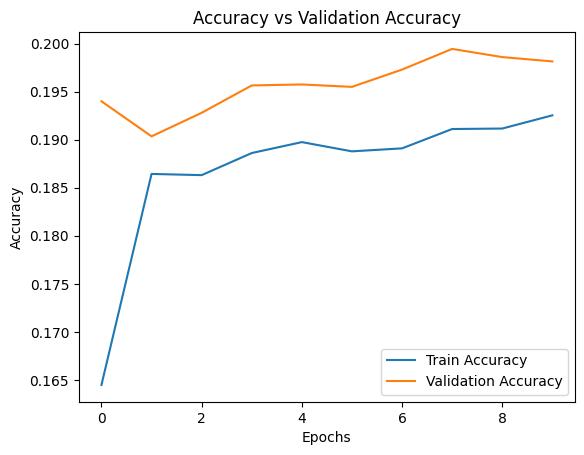

In [43]:
import matplotlib.pyplot as plt

# Plot Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Validation_Loss

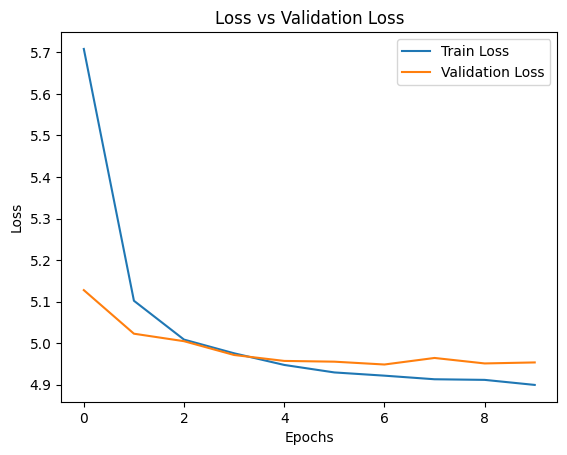

In [44]:
# Plot Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction Function

In [45]:
# ## Prediction

def predict(input_text, model, tokenizer, max_len):
    """
    Generate a response using the trained chatbot model.

    Args:
    - input_text (str): User input text.
    - model: Trained chatbot model.
    - tokenizer: Tokenizer used during training.
    - max_len (int): Maximum sequence length.

    Returns:
    - str: Generated response.
    """
    # Preprocess input text
    input_seq = tokenizer.texts_to_sequences([input_text.lower()])
    input_padded = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')

    # Initialize decoder input with the start token
    start_token = tokenizer.word_index.get('<start>', 1)  # Default to 1
    decoder_input = np.zeros((1, max_len))
    decoder_input[0, 0] = start_token

    response_tokens = []
    for i in range(1, max_len):
        # Predict next token
        predictions = model.predict([input_padded, decoder_input])
        predicted_token = np.argmax(predictions[0, i - 1, :])

        # Stop if the end token is predicted
        if predicted_token == tokenizer.word_index.get('<end>', 0):  # Default to 0
            break

        response_tokens.append(predicted_token)
        decoder_input[0, i] = predicted_token

    # Decode tokens to text
    response = tokenizer.sequences_to_texts([response_tokens])[0]
    return response.strip()

In [46]:
# Example Predictions
user_inputs = [
    "I feel stressed and overwhelmed with work.",
]

In [47]:
for user_input in user_inputs:
    response = predict(user_input, model, tokenizer, MAX_LEN)
    print(f"User: {user_input}")
    print(f"Chatbot: {response}")

1/1 [==============================] - 0s 131ms/step
User: I feel stressed and overwhelmed with work.
Chatbot: it it it it it you to to to to you you you you you you you you you you you you you you you you <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


# ROUGE-L Score

In [48]:
from rouge_score import rouge_scorer
# Initialize ROUGE scorer
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [49]:
# Efficient ROUGE-L computation
def compute_rouge_l(reference_texts, predicted_texts):
    total_score = 0
    count = 0
    for ref, pred in zip(reference_texts, predicted_texts):
        score = rouge_scorer_obj.score(ref, pred)['rougeL'].fmeasure
        total_score += score
        count += 1
    return total_score / count if count > 0 else 0

In [50]:
# Sample a subset of the test data (e.g., 10 examples for quick testing)
sample_size = 10
test_sample = test_data.sample(n=sample_size, random_state=42)

# Optimized predictions using batching
def generate_predictions(sample_data, model, tokenizer, max_len):
    predictions = []
    for input_text in sample_data['input']:
        # Generate response for each input
        response = predict(input_text, model, tokenizer, max_len)
        predictions.append(response)
    return predictions

In [51]:
# Generate predictions for the test sample
predicted_responses = generate_predictions(test_sample, model, tokenizer, MAX_LEN)

# Compute ROUGE-L for the sample
rouge_l_score = compute_rouge_l(test_sample['output'].tolist(), predicted_responses)
print(f"ROUGE-L Score (Sample of {sample_size}): {rouge_l_score}")

1/1 [==============================] - 0s 127ms/step
ROUGE-L Score (Sample of 10): 0.08420413243287107


# BERT Score

In [ ]:
from bert_score import score
import numpy as np

def optimized_bert_score(test_data, sample_size, model, tokenizer, max_len):
    """
    Optimize BERT score computation by batching predictions and using a subset of data.

    Args:
    - test_data (DataFrame): The test dataset with 'input' and 'output' columns.
    - sample_size (int): Number of samples to evaluate.
    - model (Model): The trained model for generating predictions.
    - tokenizer (Tokenizer): Tokenizer for text preprocessing.
    - max_len (int): Maximum sequence length for padding.

    Returns:
    - dict: Average Precision, Recall, and F1 scores.
    """
    # Sample a subset of the test data
    test_sample = test_data.sample(n=sample_size, random_state=42)

    # Extract inputs and references
    inputs = test_sample['input'].tolist()
    references = test_sample['output'].tolist()

    # Batch predictions to optimize performance
    batch_size = 64
    predictions = []
    for i in range(0, len(inputs), batch_size):
        batch_inputs = inputs[i:i + batch_size]
        batch_predictions = [
            predict(input_text, model, tokenizer, max_len) for input_text in batch_inputs
        ]
        predictions.extend(batch_predictions)

    # Compute BERT Score
    P, R, F1 = score(predictions, references, lang="en", verbose=False, rescale_with_baseline=False)

    # Calculate average scores
    avg_scores = {
        "Precision": np.mean(P.numpy()),
        "Recall": np.mean(R.numpy()),
        "F1": np.mean(F1.numpy())
    }

    return avg_scores

# Example Usage
sample_size = 10
scores = optimized_bert_score(test_data, sample_size, model, tokenizer, MAX_LEN)
print(f"BERT Precision (Sample): {scores['Precision']:.4f}")
print(f"BERT Recall (Sample): {scores['Recall']:.4f}")
print(f"BERT F1 (Sample): {scores['F1']:.4f}")


In [ ]:
# Extract references and predictions for the sample
references = test_sample['output'].tolist()
predictions = [predict(input_text, model, tokenizer, MAX_LEN) for input_text in test_sample['input']]

In [ ]:
# Compute BERT score for the sampled data
P, R, F1 = score(predictions, references, lang="en", verbose=True)

# Display the results
print(f"BERT Precision (Sample): {P.mean().item():.4f}")
print(f"BERT Recall (Sample): {R.mean().item():.4f}")
print(f"BERT F1 (Sample): {F1.mean().item():.4f}")


# AUC score

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_auc_optimized(model, test_input_padded, test_output_padded, test_output_padded_shifted, vocab_size, max_len, batch_size=500):

    num_samples = test_input_padded.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    all_predictions = []
    all_true_labels = []

    for batch_idx in range(num_batches):
        # Get batch start and end indices
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)

        # Get batch data
        batch_input = test_input_padded[start_idx:end_idx]
        batch_output = test_output_padded[start_idx:end_idx]
        batch_true_labels = test_output_padded_shifted[start_idx:end_idx]

        # Predict probabilities for the batch
        batch_predictions = model.predict([batch_input, batch_output])  # Shape: (batch_size, max_len, vocab_size)

        # Flatten predictions and true labels
        batch_predictions = batch_predictions.reshape(-1, vocab_size)
        batch_true_labels = batch_true_labels.flatten()

        # Filter out padding indices
        valid_indices = batch_true_labels != 0
        batch_predictions = batch_predictions[valid_indices]
        batch_true_labels = batch_true_labels[valid_indices]

        # Append to lists
        all_predictions.append(batch_predictions)
        all_true_labels.append(batch_true_labels)

    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    # Compute AUC for each class
    auc_scores = []
    for class_idx in range(1, vocab_size):  # Exclude padding token (class 0)
        class_true = (all_true_labels == class_idx).astype(int)  # Binary true labels for this class
        if np.sum(class_true) > 0:  # Ensure at least one positive sample
            class_auc = roc_auc_score(class_true, all_predictions[:, class_idx])
            auc_scores.append(class_auc)

    # Return the macro-average AUC
    return np.mean(auc_scores)

# Compute AUC for test data
try:
    auc_score = calculate_auc_optimized(
        model,
        test_input_padded,
        test_output_padded,
        test_output_padded_shifted,
        VOCAB_SIZE,
        MAX_LEN,
        batch_size=60  # Adjust batch size for efficiency
    )
    print(f"AUC Score: {auc_score}")
except MemoryError as e:
    print(f"Memory error encountered: {e}")


# LIME

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from lime.lime_text import LimeTextExplainer

# Model Wrapper
class ModelWrapper:
    def __init__(self, model, tokenizer, max_len):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len

    def predict(self, texts, batch_size=100):
        predictions = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize and pad input texts
            input_seq = self.tokenizer.texts_to_sequences(batch_texts)
            input_padded = pad_sequences(input_seq, maxlen=self.max_len, padding='post', truncating='post')

            # Create dummy decoder inputs (start token)
            start_token = self.tokenizer.word_index.get('<start>', 1)
            decoder_input = np.zeros((len(batch_texts), self.max_len))
            decoder_input[:, 0] = start_token

            # Predict probabilities for the batch
            batch_predictions = self.model.predict([input_padded, decoder_input])  # Shape: (batch_size, max_len, vocab_size)

            # Aggregate probabilities for each sequence
            sequence_probs = np.mean(batch_predictions, axis=1)  # Shape: (batch_size, vocab_size)
            predictions.append(sequence_probs)

        # Concatenate predictions from all batches
        return np.concatenate(predictions, axis=0)

In [ ]:
# Instantiate ModelWrapper
model_wrapper = ModelWrapper(model, tokenizer, MAX_LEN)

# Initialize LIME explainer
#explainer = LimeTextExplainer(class_names=list(tokenizer.word_index.keys()))

# Ensure LIME has valid class names
explainer = LimeTextExplainer(class_names=[str(i) for i in range(len(tokenizer.word_index))])

# Input text to explain
input_text = "I feel stressed and overwhelmed with work."

# Explain the prediction
explanation = explainer.explain_instance(
    input_text,
    model_wrapper.predict,  # Use batched prediction from ModelWrapper
    num_features=5,         # Highlight fewer tokens
    top_labels=1,           # Only explain the top predicted label
    num_samples=500         # Reduced perturbation samples for efficiency
)

# Visualize explanation
explanation.show_in_notebook(text=True)

# Atif

In [ ]:
# Analyze sequence lengths to determine optimal max_len
all_sequences = data['human'].apply(lambda x: word_tokenize(x.lower())) + data['gpt'].apply(lambda x: word_tokenize(x.lower()))
sequence_lengths = all_sequences.apply(len)

# Use 95th percentile for max_len
import numpy as np
max_len = int(np.percentile(sequence_lengths, 95))
print(f"Optimal max_len (95th percentile): {max_len}")

# Adjust batch size and tokenize
batch_size = 16  # Adjusted for memory optimization
tokenizer = Tokenizer()

# Fit the tokenizer on the combined text
data_combined = data['human'] + " " + data['gpt']
tokenizer.fit_on_texts(data_combined)

# Convert texts to sequences and pad them to max_len
sequences = tokenizer.texts_to_sequences(data_combined)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Split the data into train and test sets
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    padded_sequences, np.zeros((len(padded_sequences), 1)), test_size=0.2, random_state=42
)

print(f"Train data shape: {train_sequences.shape}")
print(f"Test data shape: {test_sequences.shape}")

In [ ]:
# Analyze sequence lengths to determine optimal max_len
all_sequences = data['human'].apply(lambda x: word_tokenize(x.lower())) + data['gpt'].apply(lambda x: word_tokenize(x.lower()))
sequence_lengths = all_sequences.apply(len)

# Use 95th percentile for max_len
import numpy as np
max_len = int(np.percentile(sequence_lengths, 95))
print(f"Optimal max_len (95th percentile): {max_len}")

# Adjust batch size and tokenize
batch_size = 16  # Adjusted for memory optimization
learning_rate = 0.001  # Fine-tuned learning rate
embedding_dim = 128  # Fine-tuned embedding dimensions
tokenizer = Tokenizer()

# Fit the tokenizer on the combined text
data_combined = data['human'] + " " + data['gpt']
tokenizer.fit_on_texts(data_combined)

# Convert texts to sequences and pad them to max_len
sequences = tokenizer.texts_to_sequences(data_combined)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Split the data into train and test sets
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    padded_sequences, np.zeros((len(padded_sequences), 1)), test_size=0.2, random_state=42
)

print(f"Train data shape: {train_sequences.shape}")
print(f"Test data shape: {test_sequences.shape}")